Accuracy: 0.9256756756756757
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93       370
           1       0.93      0.92      0.93       370

    accuracy                           0.93       740
   macro avg       0.93      0.93      0.93       740
weighted avg       0.93      0.93      0.93       740



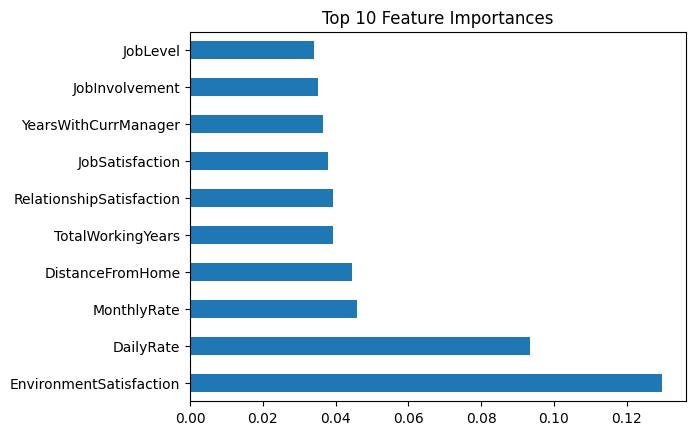

In [3]:

import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
drop_columns = ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours']
df = df.drop(drop_columns, axis=1)

low_variance_cols = [col for col in df.columns if df[col].nunique() == 1]
df = df.drop(columns=low_variance_cols)

categorical_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

numeric_cols = ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 
                'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 
                'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 
                'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 
                'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 
                'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

X = df.drop(columns=['Attrition'])
y = LabelEncoder().fit_transform(df['Attrition'])

smote_tomek = SMOTETomek(random_state=42)
X_balanced, y_balanced = smote_tomek.fit_resample(X, y)

pca = PCA(n_components=0.95, random_state=42) 
X_pca = pca.fit_transform(X_balanced)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

xgb = XGBClassifier(random_state=42, eval_metric='logloss')
lgbm = LGBMClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)

stacking_clf = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('lgbm', lgbm),
        ('rf', rf),
        ('gb', gb)
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5,
    n_jobs=-1
)

stacking_clf.fit(X_train, y_train)

y_pred = stacking_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

feature_importances = pd.Series(stacking_clf.named_estimators_['xgb'].feature_importances_, 
                                 index=X.columns[:pca.n_components_])
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.show()
